# Задание для отдела аналитики

In [2]:
import pandas as pd
import numpy as np
import math
import sys
import copy
import scipy
from sklearn.cluster import KMeans
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter
from scipy.stats import pearsonr, spearmanr, kendalltau

from sklearn.preprocessing import Binarizer
from scipy.stats.mstats import mode

from skimage.io import imread, imshow

import warnings
warnings.filterwarnings("ignore")

Считываем данные и отрезаем первый столбец: id-шники сессий.

In [5]:
data = pd.read_table('task1/analytics_task', names=range(101))
data.shape

(45578, 101)

In [6]:
transactions = data.ix[:,1:].astype('float').as_matrix()
transactions.shape

(45578, 100)

На первый взгляд кажется, что в таблице есть несколько полностью нулевых столбцов. Проверим эту догадку:

In [7]:
goodfeatures = []
print "Columns with same values:"
for i, column in enumerate(transactions.T):
    if max(column) == min(column):
        print i, max(column)
    else:
        goodfeatures.append(i)

Columns with same values:
37 0.0
46 0.0
54 0.0
56 0.0
73 0.0
74 0.0
75 0.0
77 0.0
85 1.0
92 0.0
93 0.0
96 0.0
97 0.0
98 0.0
99 0.0


Интересно, здесь есть столбцы из одних нулей и один столбец, состоящий из одних единиц. Эти признаки никакой информации не добавляют, можно их смело удалять

In [8]:
transactions = transactions[:, goodfeatures]
print transactions.shape

(45578, 85)


Проанализируем оставшиеся признаки:

##### Анализ признаков

Смотрим минимум, максимум и количество ненулевых значений для каждого признака

In [231]:
for i in range(85):
    print "{0}: min {1}, max {2}, {3:.3f}% nonzero". format(i, min(transactions.T[i]), max(transactions.T[i]), np.count_nonzero(transactions.T[i]) * 100.0 / len(transactions.T[i]))

0: min 0.0, max 6300.0, 98.449% nonzero
1: min 0.0, max 795.0, 79.060% nonzero
2: min 0.0, max 761.0, 45.671% nonzero
3: min 0.0, max 500.0, 93.808% nonzero
4: min 0.0, max 1.84467440737e+19, 97.892% nonzero
5: min 0.0, max 86375.0, 99.974% nonzero
6: min 0.0, max 88.0, 1.924% nonzero
7: min 0.0, max 100.0, 22.798% nonzero
8: min 0.0, max 1.0, 48.978% nonzero
9: min 0.0, max 197.0, 99.987% nonzero
10: min 0.0, max 76.0, 7.337% nonzero
11: min 0.0, max 244.0, 80.743% nonzero
12: min 0.0, max 107.0, 30.767% nonzero
13: min 0.0, max 100.0, 30.767% nonzero
14: min 0.0, max 544.0, 99.443% nonzero
15: min 1.0, max 302.0, 100.000% nonzero
16: min 0.0, max 41.0, 0.044% nonzero
17: min 0.0, max 5.0, 0.009% nonzero
18: min 0.0, max 287.0, 98.449% nonzero
19: min 0.0, max 287.0, 63.722% nonzero
20: min 0.0, max 39.0, 17.612% nonzero
21: min 0.0, max 20.0, 3.188% nonzero
22: min 0.0, max 880.0, 63.976% nonzero
23: min 0.0, max 500.0, 6.064% nonzero
24: min 0.0, max 104.0, 9.145% nonzero
25: min 0.

Нулей нет всего в двух столбцах (15 и 70). Посмотрим на гистограммы для них:

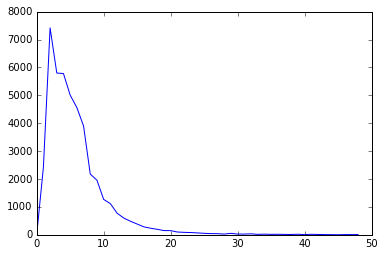

In [13]:
plt.plot(np.histogram(transactions.T[15], bins=range(50))[0])
plt.show()

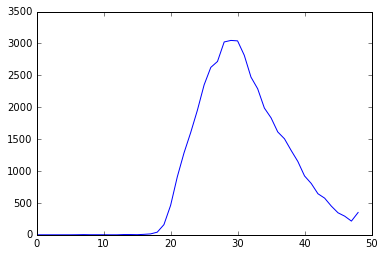

In [14]:
plt.plot(np.histogram(transactions.T[70], bins=range(50))[0])
plt.show()

Хочется понять, есть ли какая-то корреляция между этими признаками. Для того, чтобы исследовать статистическую зависимость между двумя переменными, будем использовать три критерия: Pearson correlation coefficient, Spearman rank-order correlation coefficient и Kendall Tau correlation coefficient.

Pearson correlation coefficient - мера линейной корреляции между двумя переменными. Тот факт, что коэффициент положительный, интерпретируется как "если переменная 1 возрастает, то и переменная 2 возрастает", отрицательность интерпретируется соответственно как "если переменная 1 возрастает, то переменная 2 убывает". Ноль означает отсутствие корреляции между признаками.

Spearman rank-order correlation coefficient описывает, насколько хорошо зависимость между двумя переменными может быть описана монотонной функцией. Определяется как корреляционный коэффициент Пирсона для отранжированных переменных.

Формула для Kendall Tau correlation coefficient - $$\dfrac{P - Q}{\sqrt{(P + Q + T) * (P + Q + U)}}$$
Здесь P - количество согласованных пар, Q - несогласованных. Пара согласована, если выполнены оба условия $x_i < x_j$ и $y_i < y_j$ (или наоборот). $T$ - количество связей только в $x$, $U$ - только в $y$.

In [221]:
def find_correlations(transactions, x, y):
    print '{0} and {1} features:'.format(x, y)
    print 'PearsonrResult', pearsonr(transactions.T[x], transactions.T[y])
    print spearmanr(transactions.T[x], transactions.T[y])
    print kendalltau(transactions.T[x], transactions.T[y])
    print 
    
def filter_correlations(transactions, features, pearson_t):
    for i, j in itertools.combinations(features,2):
        if pearsonr(transactions.T[i], transactions.T[j])[0] > pearson_t:
            print '{0} and {1} features:'.format(i, j)
            print 'PearsonrResult', pearsonr(transactions.T[i], transactions.T[j])
            print spearmanr(transactions.T[i], transactions.T[j])
            print kendalltau(transactions.T[i], transactions.T[j])
            print 

In [239]:
find_correlations(transactions, 15, 70)

15 and 70 features:
PearsonrResult (0.11300421956462459, 2.1107412229867121e-129)
SpearmanrResult(correlation=0.065713781207572694, pvalue=8.3803051257315272e-45)
KendalltauResult(correlation=0.047576837521190331, pvalue=2.0653689699067576e-52)



Интерпертировать такой результат довольно сложно. Перед тем, как искать в датасете ассоциативные правила, попробуем посмотреть на корреляции всевозможных пар признаков друг с другом (вдруг что-то хорошее получится?).

In [241]:
filter_correlations(transactions, range(85), 0.9)

4 and 83 features:
PearsonrResult (1.0, 0.0)
SpearmanrResult(correlation=0.043415623786015392, pvalue=1.8111584930848187e-20)
KendalltauResult(correlation=0.042022670434706248, pvalue=2.8151751014965684e-41)

9 and 49 features:
PearsonrResult (0.95245740970210124, 0.0)
SpearmanrResult(correlation=0.82800853875657465, pvalue=0.0)
KendalltauResult(correlation=0.77894358909492045, pvalue=0.0)

11 and 35 features:
PearsonrResult (0.97591310671290488, 0.0)
SpearmanrResult(correlation=0.92421989641929325, pvalue=0.0)
KendalltauResult(correlation=0.87594305162631603, pvalue=0.0)

11 and 39 features:
PearsonrResult (0.90152060345170593, 0.0)
SpearmanrResult(correlation=0.69725484319058872, pvalue=0.0)
KendalltauResult(correlation=0.62123902538911491, pvalue=0.0)

15 and 42 features:
PearsonrResult (0.97186624251300047, 0.0)
SpearmanrResult(correlation=0.97554759785375045, pvalue=0.0)
KendalltauResult(correlation=0.94279331846884096, pvalue=0.0)

15 and 46 features:
PearsonrResult (0.9278710605

Нашли 12 пар признаков, между которыми есть достаточно большая корреляция. В то же время найденные взаимосвязи могут оказаться ложными зависимостями. Посмотрим на гистограммы этих признаков:

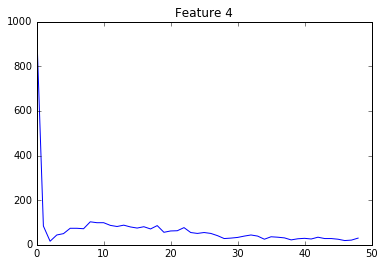

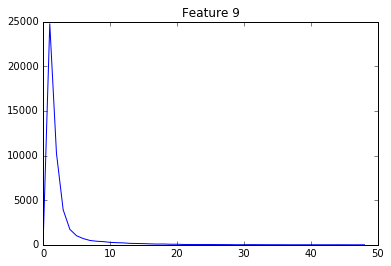

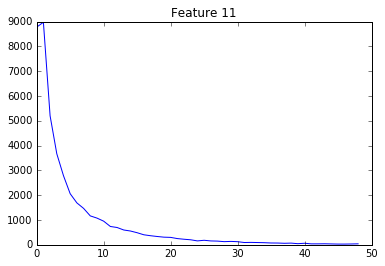

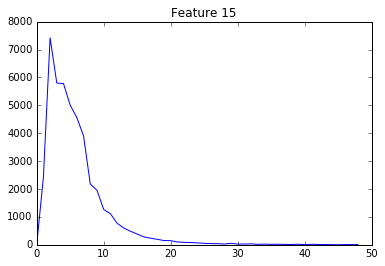

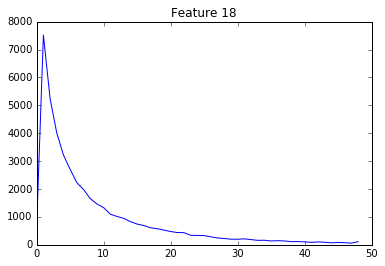

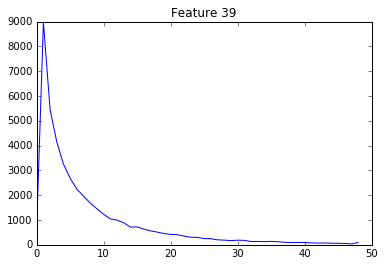

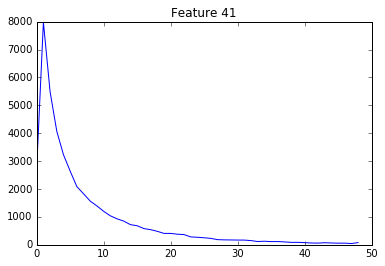

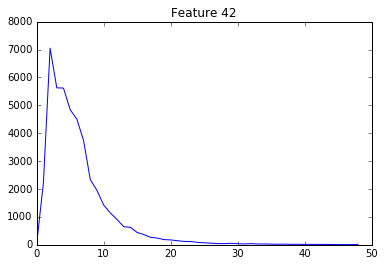

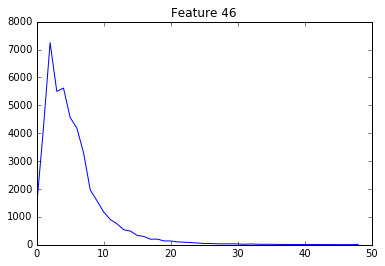

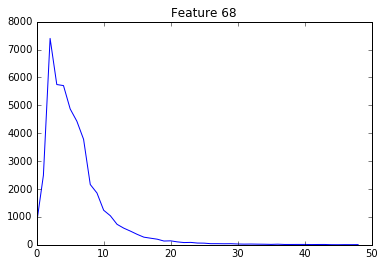

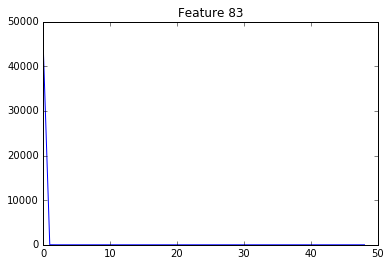

In [17]:
for i in sorted([46,68,42,18,41,39,15,11,9,4,83]):
    f, ax = plt.subplots()
    ax.plot(np.histogram(transactions.T[i], bins=range(50))[0])
    ax.set_title("Feature {0}".format(i))

По графикам убеждаемся, что 15, 42, 46, 68 и 25 имеют очень похожие гистограммы.

Эти признаки явно описывают какую-то одну группу характеристик сессий.

Смотрим на гистограммы всех признаков и пытаемся найти еще подобные группы признаков:

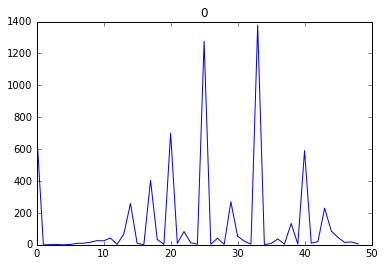

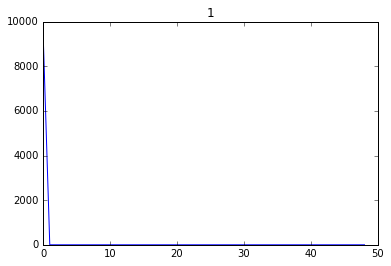

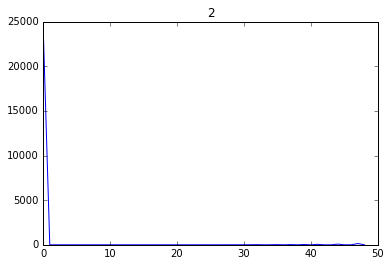

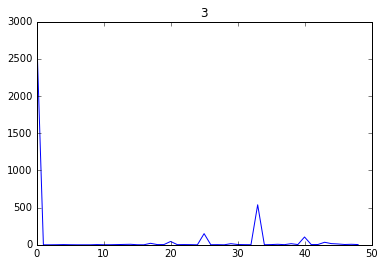

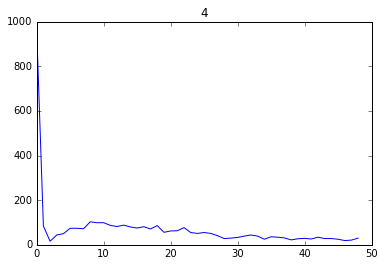

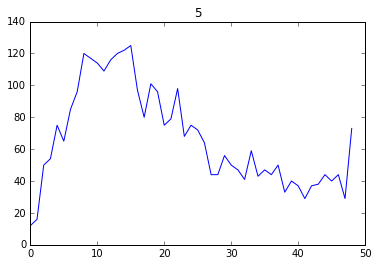

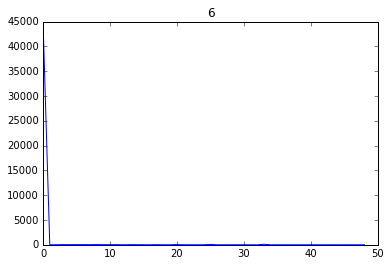

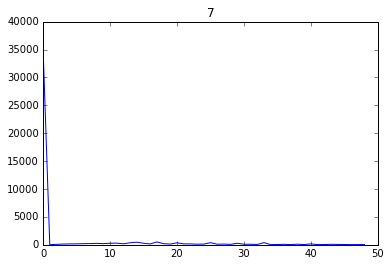

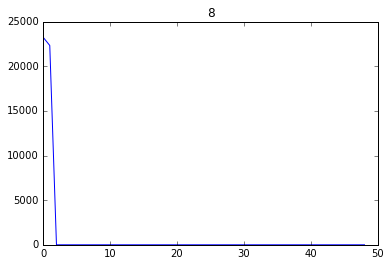

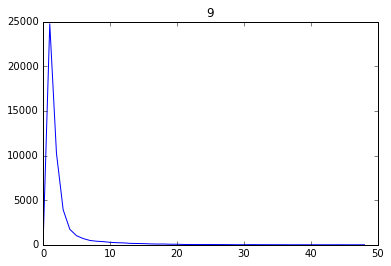

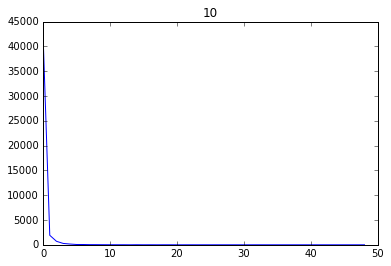

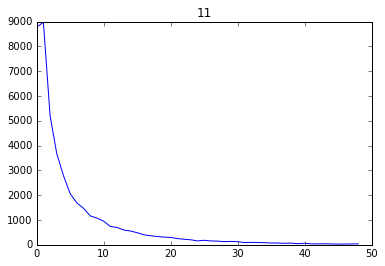

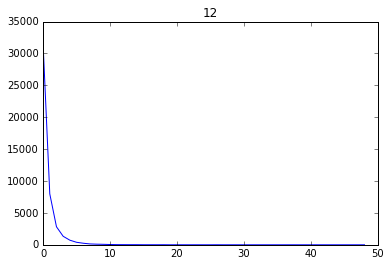

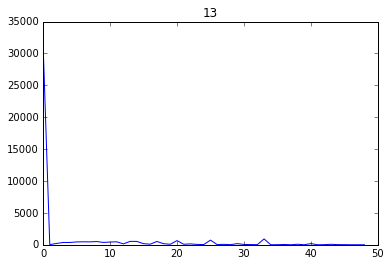

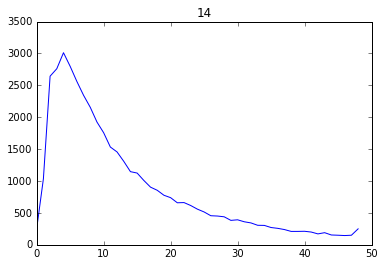

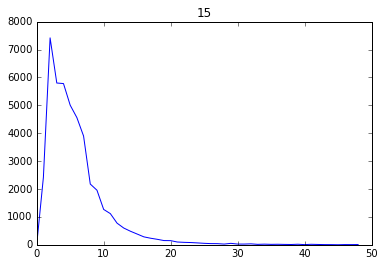

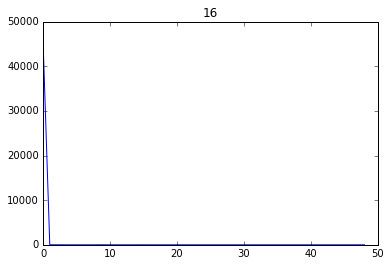

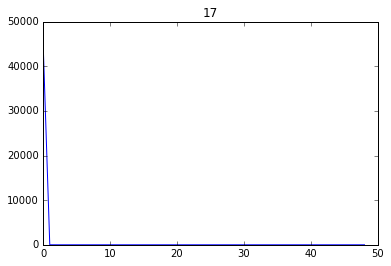

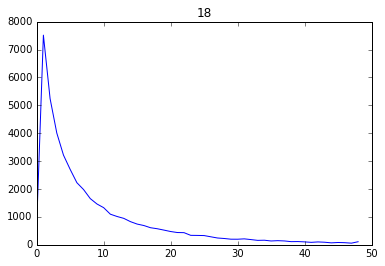

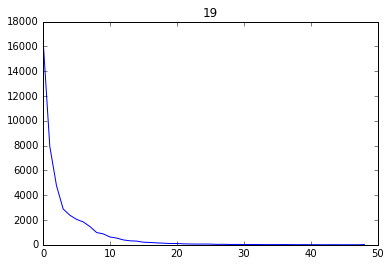

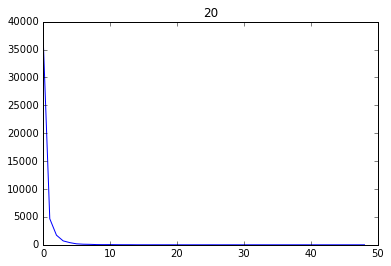

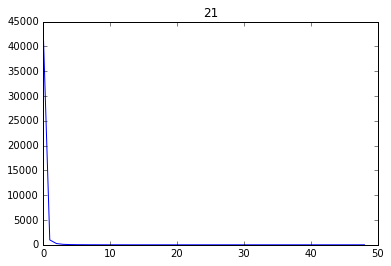

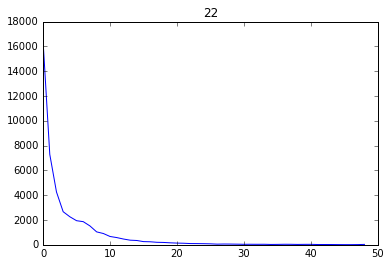

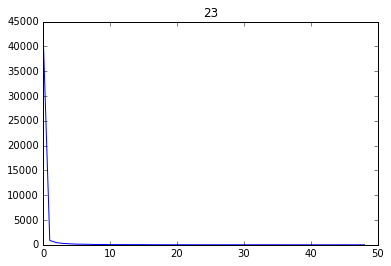

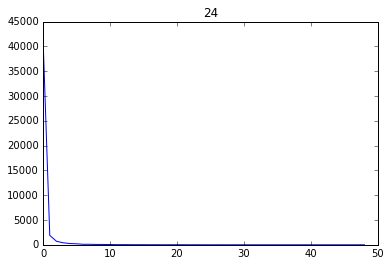

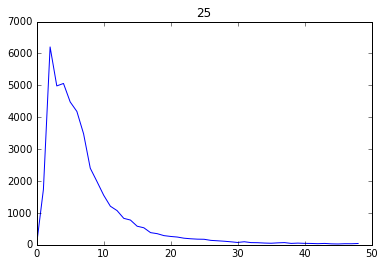

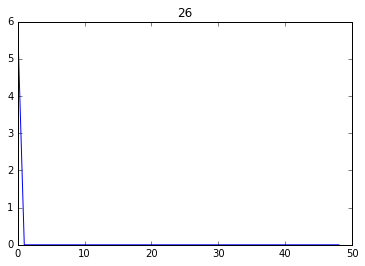

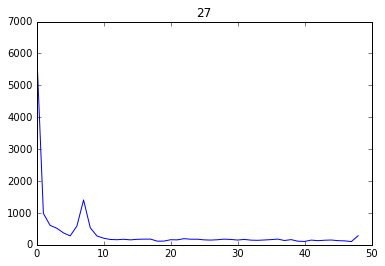

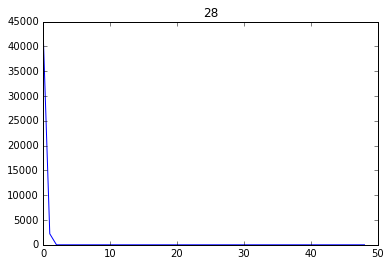

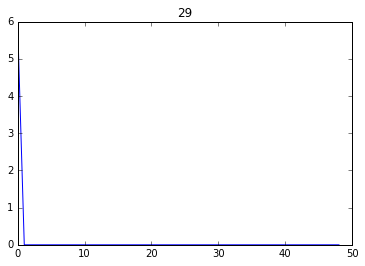

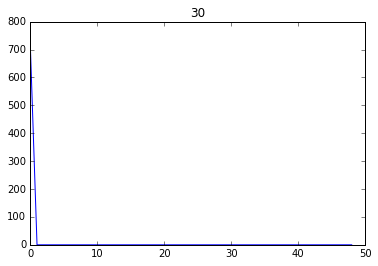

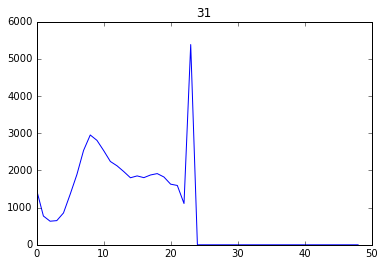

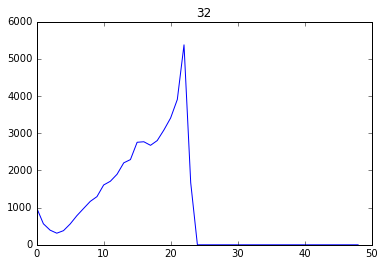

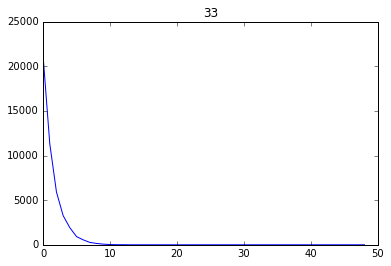

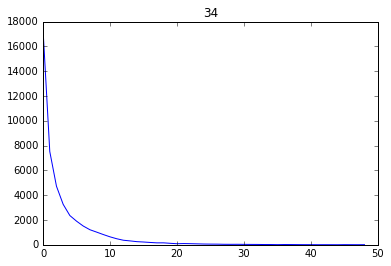

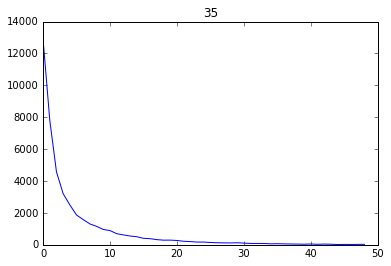

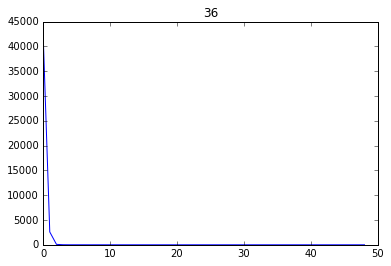

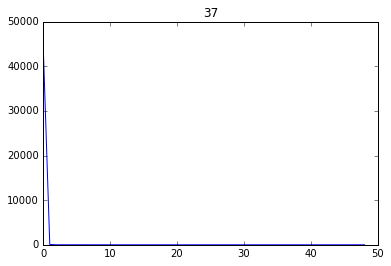

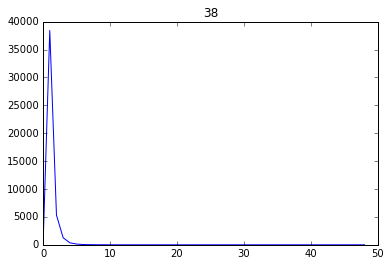

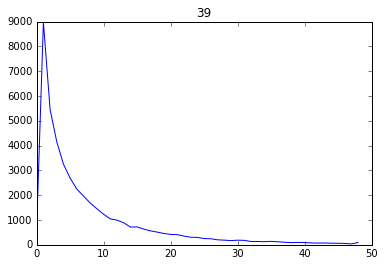

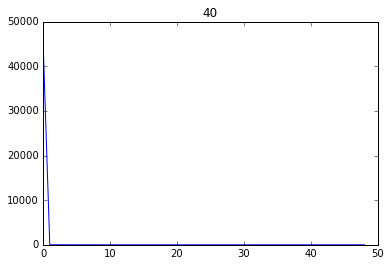

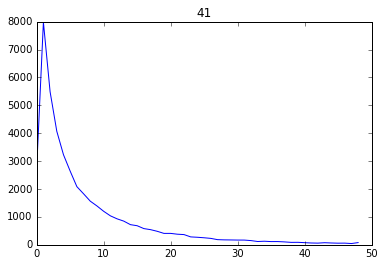

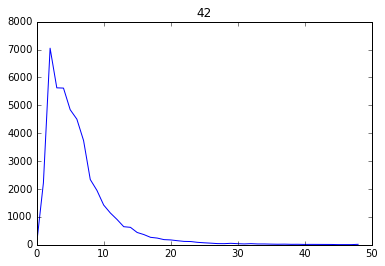

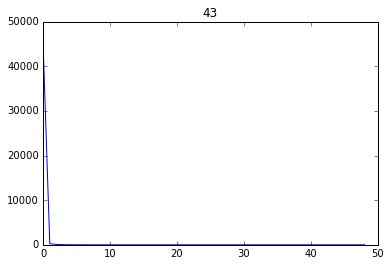

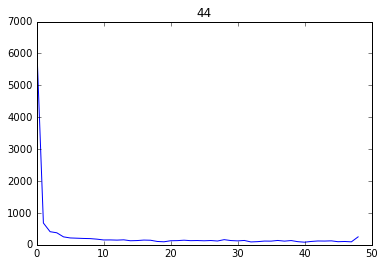

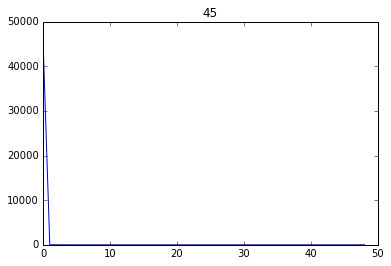

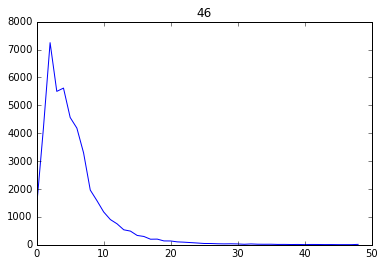

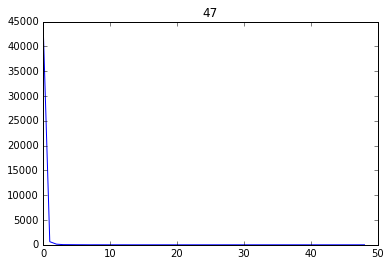

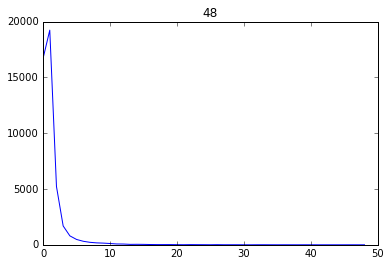

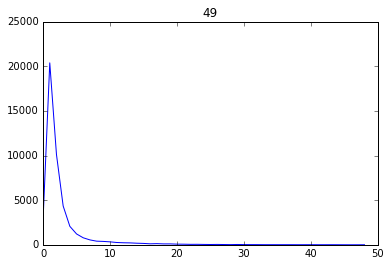

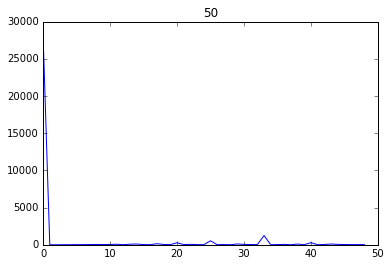

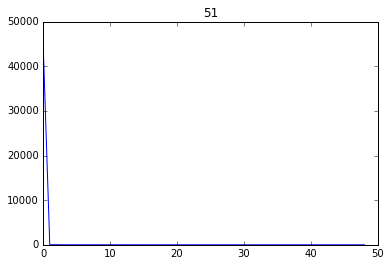

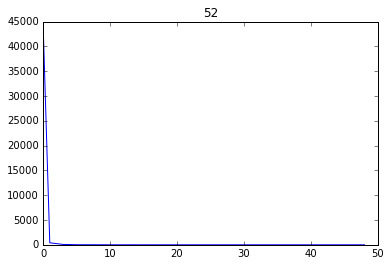

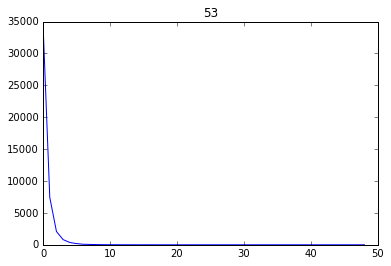

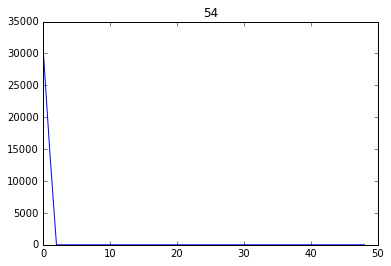

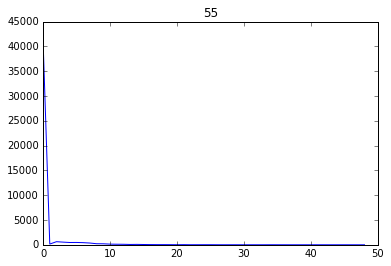

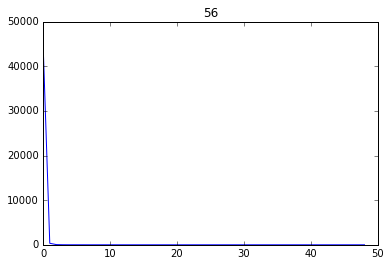

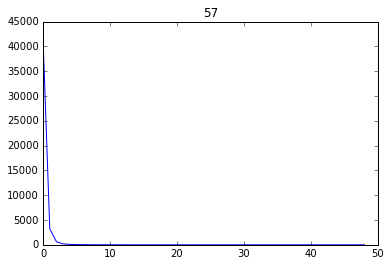

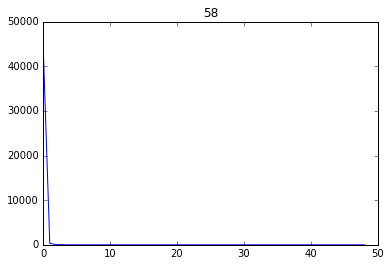

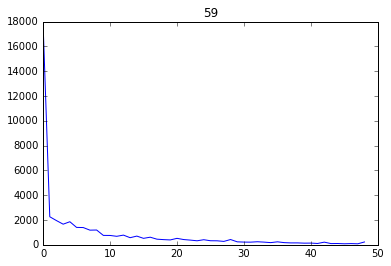

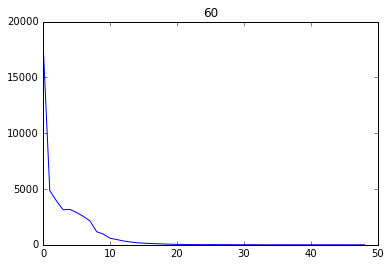

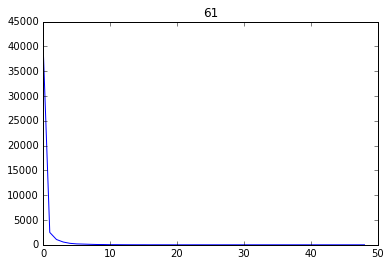

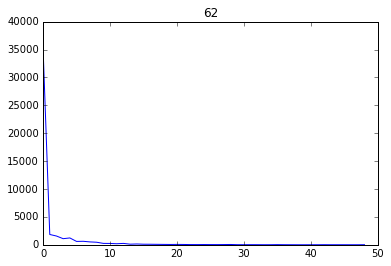

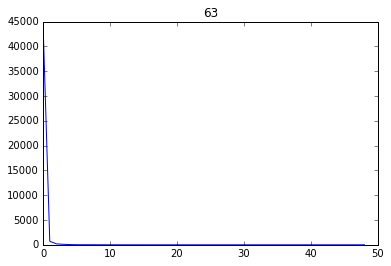

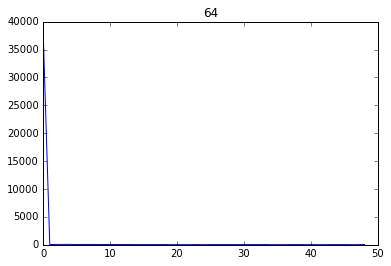

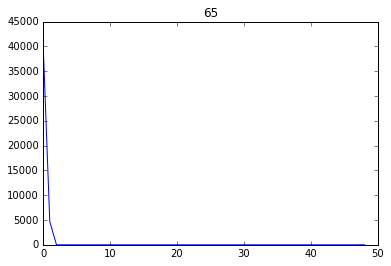

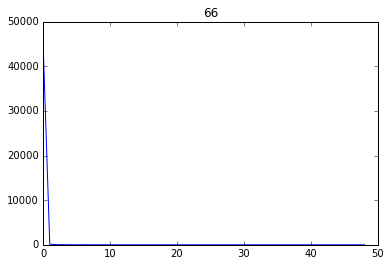

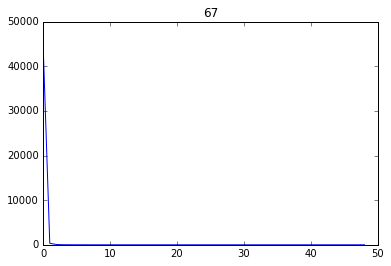

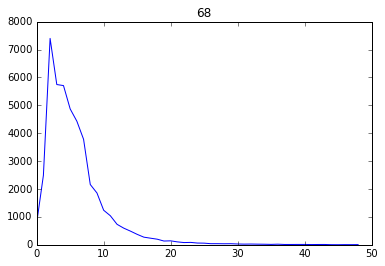

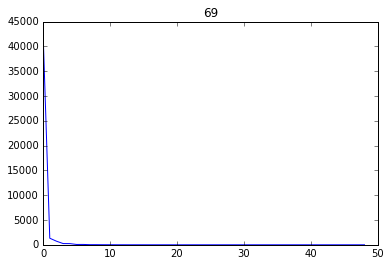

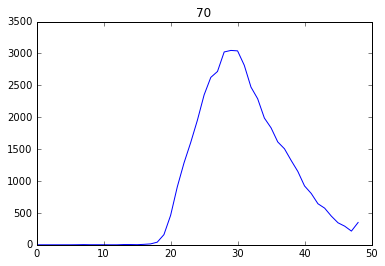

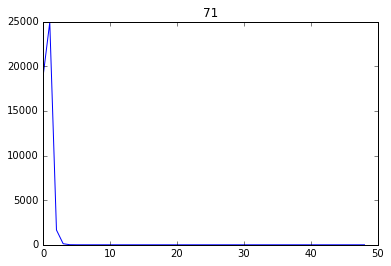

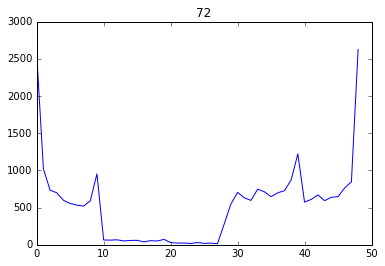

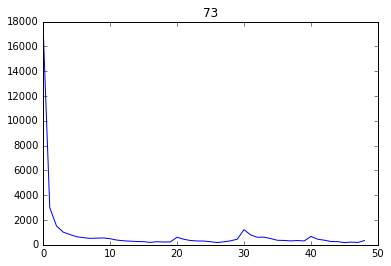

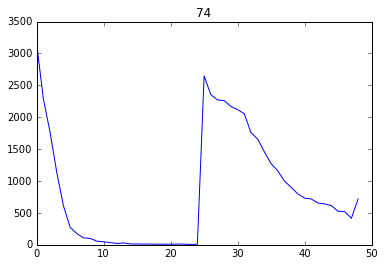

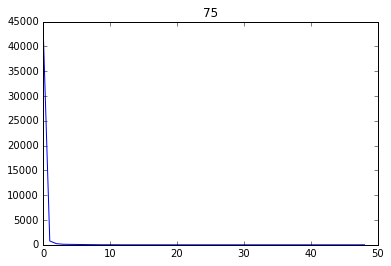

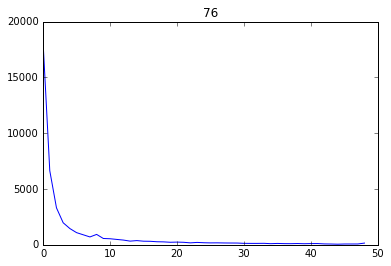

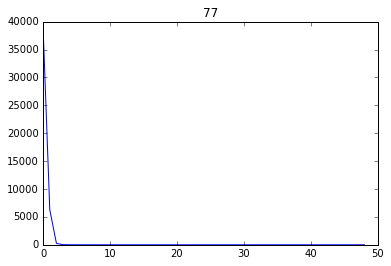

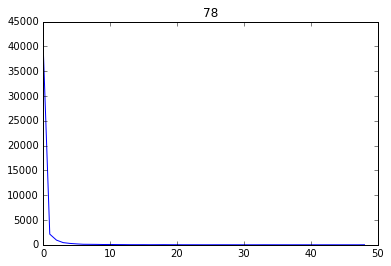

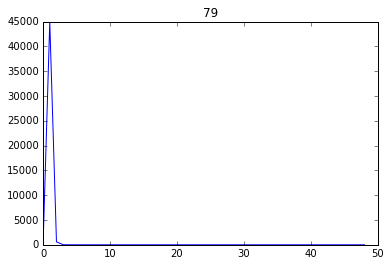

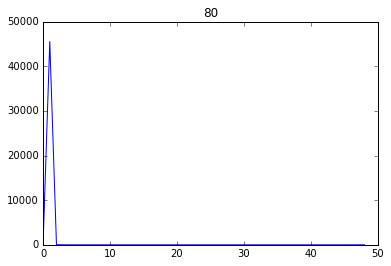

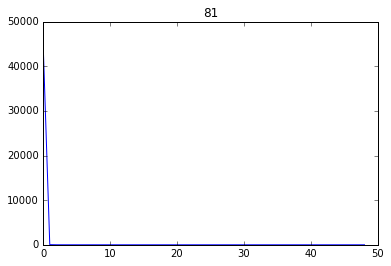

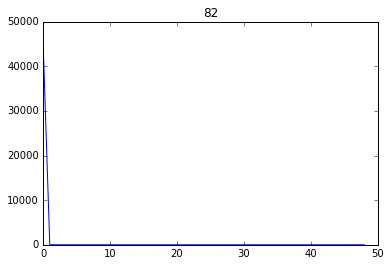

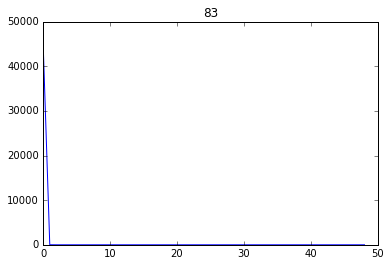

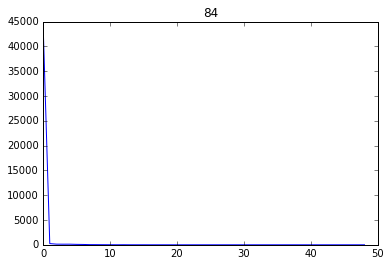

In [19]:
for i in range(85):
    f, ax = plt.subplots()
    ax.plot(np.histogram(transactions.T[i], bins=range(50))[0])
    ax.set_title(i)

Посмотрим на признаки и попытаемся их интерпретировать

Признаки 31, 32 и 74 имеют необычную форму (и их гистограммы похожи друг на друга)

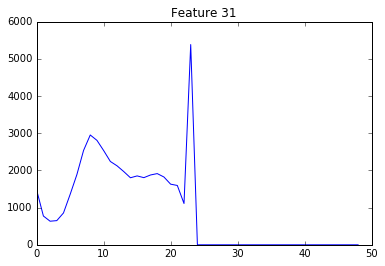

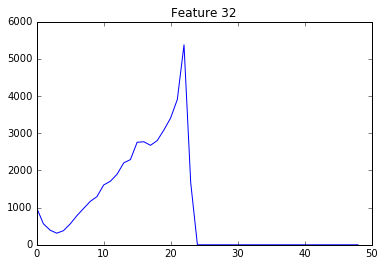

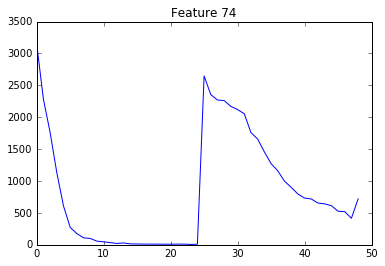

In [18]:
for i in sorted([31,32,74]):
    f, ax = plt.subplots()
    ax.plot(np.histogram(transactions.T[i], bins=range(50))[0])
    ax.set_title("Feature {0}".format(i))

In [269]:
filter_correlations(transactions, [31,32,74], 0.5)

31 and 32 features:
PearsonrResult (0.50745574461045129, 0.0)
SpearmanrResult(correlation=0.53755024238192817, pvalue=0.0)
KendalltauResult(correlation=0.46488027470523363, pvalue=0.0)



Смотрим на другие признаки с интересными гистограммами. Например, на признак 26:

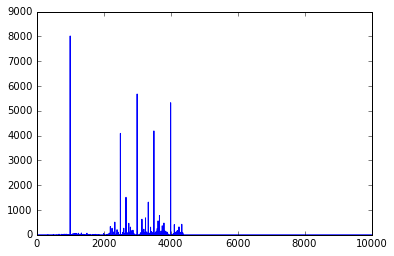

In [24]:
plt.plot(np.histogram(transactions.T[26], bins=range(10000))[0])
plt.show()

Посмотрим на самые часто встречающиеся значения в этом признаке:

In [21]:
print Counter(transactions.T[26]).most_common(10)

[(1000.0, 8017), (3000.0, 5677), (4000.0, 5325), (3500.0, 4188), (2500.0, 4090), (2667.0, 1512), (3333.0, 1317), (3667.0, 781), (3250.0, 682), (3143.0, 628)]


26-й признак наводит на мысль. В нем самые часто встречающиеся значения - целые круглые числа. Дальше по убыванию меры встречаемости идут числа (3333, 3667) которые наводят на мысль, что это число - одна третья какого-то другого числа, число 3250 наводит на мысль об одной четвертой, 3143 - об одной седьмой (1.7 = 0.142857...). Похоже, что это признак - доли чего-то (ну или какие-то хитро нормированные признаки). Надо взять это на заметку

Рассмотрим нулевой признак:

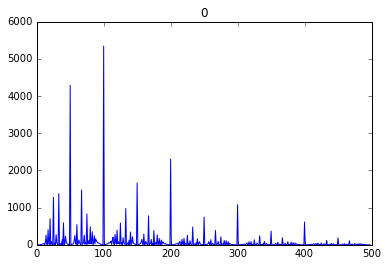

In [25]:
f, ax = plt.subplots()
ax.plot(np.histogram(transactions.T[0], bins=range(500))[0])
ax.set_title(0)

Тут явно видна закономерность: на гистограмме присутствуют пики, они расположены через примерно равные промежутки. При этом значения пиков убывают (чем больше значение, тем меньшее количество раз, оно встречается).

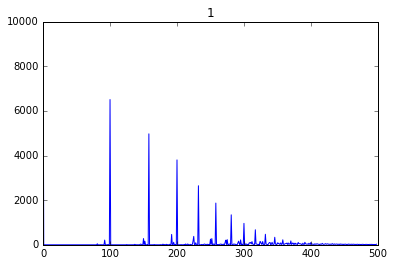

In [26]:
f, ax = plt.subplots()
ax.plot(np.histogram(transactions.T[1], bins=range(500))[0])
ax.set_title(1)

Здесь тоже видна закономерность

Теперь посмотрим на 72-й признак:

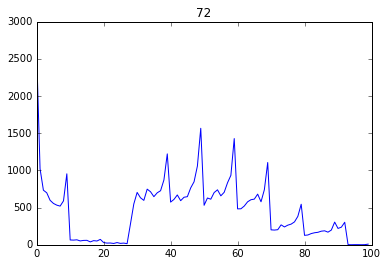

In [275]:
f, ax = plt.subplots()
ax.plot([len(transactions.T[72][transactions.T[72] == x]) for x in range(100)])
ax.set_title(72)

Здесь видно, что какие значения встречаются чаще предыдущих (причем заметна некоторая периодичность, часто встречаются те значения, которые отстоят друг от друга на расстояние примерно равное 10 на промежутке от 40 до 80)

In [276]:
print Counter(transactions.T[72]).most_common(10)

[(0.0, 2566), (49.0, 1566), (59.0, 1428), (39.0, 1222), (69.0, 1106), (48.0, 1059), (1.0, 1022), (9.0, 954), (58.0, 934), (38.0, 872)]


Кроме нуля, часто встречаемые значения - 49, 59, 39, 69. Все они различаются друг относительно друга на 10.

Мне показались странными признаки 29 и 30. Они оба сильно отличаются от всех остальных признаков по диапазону принимаемых значений и явно взаимосвязаны друг с другом. Кроме того, у них большие значения. Эти признаки похожи на айдишники. Например, на айдишник сессии. Но тогда непонятно, почему их два?

In [41]:
print Counter(transactions.T[29]).most_common(10)
print Counter(transactions.T[30]).most_common(10)

[(1375905638.0, 12), (1375905603.0, 11), (1375905645.0, 11), (1375905710.0, 11), (1375905647.0, 10), (1375905685.0, 10), (1375905616.0, 9), (1375905630.0, 9), (1375905649.0, 9), (1375905687.0, 9)]
[(0.0, 715), (1375905613.0, 16), (1375905657.0, 16), (1375905615.0, 15), (1375905618.0, 15), (1375905731.0, 15), (1375905606.0, 14), (1375905609.0, 14), (1375905616.0, 14), (1375905689.0, 14)]


Часто встречающиеся значения отличаются друг от друга несильно.

Смотрим на графики:

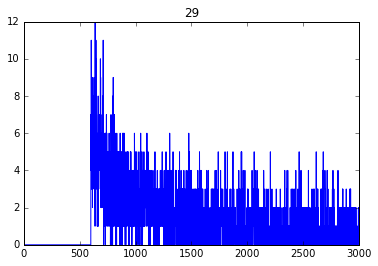

In [33]:
f, ax = plt.subplots()
ax.plot(np.histogram(transactions.T[29], range(1375905000, 1375908000))[0])
ax.set_title(29)

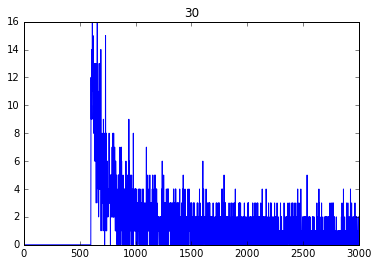

In [35]:
f, ax = plt.subplots()
ax.plot(np.histogram(transactions.T[30], range(1375905000, 1375908000))[0])
ax.set_title(30)

Посмотрим, насколько различаются значения в 29 и 30 столбиках

In [49]:
diffs = np.array([transactions[i][30] - value for i, value in enumerate(transactions.T[29])])
print diffs[diffs < 0].size

3036


Интересно, значение в 30 стоблике почти всегда больше значения в 29. Есть гипотеза, что эти два признака означают начало и конец сессии. Возможно, это какие-то специальные айдишники, обозначающие начало и конец сессии, но это вряд ли, потому что в столбиках есть повторяющиеся признаки. Скорее всего, это время начала и конца сессии.

Плюс еще есть много признаков, гистограммы которых по форме похожи на ветвь графика функции 1/x. Такие признаки могут быть зависимы друг относительно друга. 

In [63]:
a = [11,19,22,34,35,76]
filter_correlations(transactions, a, 0.5)

11 and 35 features:
PearsonrResult (0.97591310671290488, 0.0)
SpearmanrResult(correlation=0.92421989641929325, pvalue=0.0)
KendalltauResult(correlation=0.87594305162631603, pvalue=0.0)

19 and 22 features:
PearsonrResult (0.52871912632634899, 0.0)
SpearmanrResult(correlation=0.9694648722079493, pvalue=0.0)
KendalltauResult(correlation=0.93602719983310068, pvalue=0.0)

19 and 34 features:
PearsonrResult (0.68710744667449186, 0.0)
SpearmanrResult(correlation=0.49494442967072566, pvalue=0.0)
KendalltauResult(correlation=0.40678731684566755, pvalue=0.0)



По полученным результатам трудно утверждать, что эти признаки взаимосвязаны (среди всей группы только три пары с высокими коэффициентами корреляции).

Попробуем то же самое для другой группы признаков:

In [60]:
find_correlations(transactions, 46, 42)
find_correlations(transactions, 48, 49)
find_correlations(transactions, 49, 42)

46 and 42 features:
PearsonrResult (0.92996241687767456, 0.0)
SpearmanrResult(correlation=0.90497373935606562, pvalue=0.0)
KendalltauResult(correlation=0.83851210865845349, pvalue=0.0)

48 and 49 features:
PearsonrResult (0.82614250164964909, 0.0)
SpearmanrResult(correlation=0.51914642806047162, pvalue=0.0)
KendalltauResult(correlation=0.46479458078296138, pvalue=0.0)

49 and 42 features:
PearsonrResult (0.80868675845760818, 0.0)
SpearmanrResult(correlation=0.57664404579465844, pvalue=0.0)
KendalltauResult(correlation=0.46835114642998316, pvalue=0.0)



49, 48, 46 и 42 - эти признаки точно взаимосвязаны друг с другом.

### Поиск ассоциативных правил

##### Бинаризация признаков

Бинаризация признаков - сложная задача. От того, какие threshold'ы мы подберем, будет напрямую зависеть, какие ассоциативные правила мы сможем найти. Будем использовать несколько подходов к бинаризации признаков и сравним полученные результаты.

Будем использовать несколько подходов к бинаризации. В статье http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.14.4447&rep=rep1&type=pdf приводятся 4 метода:
1) Использование среднего значения по каждому признаку (меньше mean - 0, больше mean - 1).
2) То же самое, но для медианы.
3) Можно попробовать тот же метод для моды, но в вышеупомянутой статье описаны эксперименты, где поиск правил по бинаризованным данным, где порогом является мода, дает качество хуже, чем при использовании среднего значения и медианы. Мода чувствительна к ошибкам (или выбросам) в данных, из-за этого бинаризация, основанная на ней может работать хуже. Впрочем, на нашем датасете это может сработать, попробуем и медиану тоже.
4) Принципиально другой подход - использовать методы для кластеризации для того, что поделить значения признаков на две группы. Попробуем делать кластеризацию опираясь на данные только об одном признаке, о паре признаков, о тройке, а также о группах признаков, найденных ранее (см. подробнее далее в отчете).

Откровенно говоря, первые три метода вызывают у меня огромные подозрения. 4-ый метод стоит попробовать, он неожиданно может дать адекватный результат. Но самым логичным мне кажется следующий метод: 

##### Бинаризация 

Есть признаки, которых очень мало уникальных значений (то есть в которых почти всегда стоит одно и то же значение). Они не очень информативны, можно их удалить из выборки

In [51]:
good_features = []
binary_features = []
for i, feature in enumerate(transactions.T):
    most_common_perc = Counter(feature).most_common(1)[0][1] * 1.0 / transactions.shape[0]
    if most_common_perc < 0.9 and len(np.unique(feature)) != 2:
        good_features.append(i)
    if len(np.unique(feature)) == 2:
        binary_features.append(i)
        
binary_transactions = transactions[:, binary_features]
transactions = transactions[:, good_features]
print transactions.shape

(45578, 51)


Для оставшихся 51 признака будем их область значений делить на несколько частей и смотреть, к какой части относится каждое значение

In [52]:
bins = 10
feature_bounds = []
for feature in transactions.T:
    feature_bounds.append(np.linspace(min(feature), max(feature), bins + 1))

In [53]:
X = np.zeros((transactions.shape[0], bins * transactions.shape[1]))
for i, feature in enumerate(transactions.T):
    for j, f in enumerate(feature):
        X[j, np.argmin(np.abs(feature_bounds[i] - f)) - 1 + i * bins] = 1

In [55]:
X = np.column_stack((X, binary_transactions))
print X.shape

(45578, 520)


Сделаем бинаризацию и по тем 4 методам из статьи, а потом будет сравнивать результаты

##### threshold = mean, median, mode

Попробуем методы из статьи http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.14.4447&rep=rep1&type=pdf (делим на 0 и 1 относительно среднего значения, медианы и моды):

In [56]:
trans_len = transactions.shape[0]
mean_transactions = np.empty((trans_len, 0))
for feature in transactions.T:
    mean_bin = Binarizer(threshold=np.mean(feature))
    bin_feature = mean_bin.transform(feature)
    mean_transactions = np.column_stack((mean_transactions, bin_feature.T))

In [57]:
median_transactions = np.empty((trans_len, 0))
for feature in transactions.T:
    median_bin = Binarizer(threshold=np.median(feature))
    bin_feature = median_bin.transform(feature)
    median_transactions = np.column_stack((median_transactions, bin_feature.T))

In [58]:
mode_transactions = np.empty((trans_len, 0))
for feature in transactions.T:
    mode_bin = Binarizer(threshold=mode(feature)[0][0])
    bin_feature = mode_bin.transform(feature)
    mode_transactions = np.column_stack((mode_transactions, bin_feature.T))

##### Бинаризация с помощью кластеризации

Вообще подбирать threshold, основываясь только на внешнем виде гистограмм признаков, довольно проблематично. Попробуем с помощью какого-нибудь алгоритма кластеризации, например, с помощью kmeans, делить каждый признак на два класса. 

In [59]:
kmeans_transactions = np.empty((trans_len,0))

for i in range(transactions.shape[1]):
    kmeans = KMeans(n_clusters = 2)
    y_pred = kmeans.fit_predict([[feature] for feature in transactions.T[i]])
    #if 45 < sum(y_pred) * 100.0 / len(y_pred) < 55:
        #print i, sum(y_pred) * 100.0 / len(y_pred)
    kmeans_transactions = np.column_stack((kmeans_transactions, np.array(y_pred)))

In [60]:
print kmeans_transactions.shape

(45578, 51)


Попробуем делать кластеризацию не по одному признаку, а по нескольку:

In [62]:
import copy

feature_num = transactions.shape[1]
for i, j in itertools.combinations(range(feature_num), 2):
    kmeans = KMeans(n_clusters = 2)
    y_pred = kmeans.fit_predict(transactions[:,[i,j]])
    if 20 < sum(y_pred) * 100.0 / len(y_pred) < 80:
        #print i, j, sum(y_pred) * 100.0 / len(y_pred)
        kmeans_transactions = np.append(kmeans_transactions, np.array(y_pred).reshape(len(y_pred), 1), axis=1)

In [63]:
print kmeans_transactions.shape

(45578, 442)


##### Ассоциативные правила. Apriori.

Метрики для оценки качества найденных правил:

In [65]:
def support(transactions, itemset):
    ids = []
    for id, transaction in enumerate(transactions):
        if all(transaction[itemset] != 0):
            ids.append(id)
    return len(ids) * 1.0 / len(transactions)

def confidence(transactions, x, y):
    return support(transactions, list(set(x + y))) / support(transactions, x)

def lift(transactions, x, y):
    return support(transactions, list(set(x + y))) / (support(transactions, x) * support(transactions, y)) 

def conviction(transactions, x, y):
    if confidence(transactions, x, y) != 1:
        return (1 - support(transactions, y)) / (1 - confidence(transactions, x, y))
    else:
        return np.inf
        

Например, ищем метрики для произвольных наборов признаков:

In [68]:
print support(transactions, [15])
print confidence(transactions, range(6,8), [15])
print lift(transactions, range(6,8), [15])
print conviction(transactions, range(6,8), [15])

0.176115669841
0.25964777211
1.47430249872
1.11282751523


Теперь надо научиться искать frequent itemsets. Будем делать это с помощью алгоритма Apriori.

Алгоритм работает довольно долго.

In [71]:
def apriori(transactions, delta):
    freq_itemsets = []
    #find set of frequent 1-element sets
    one_itemsets = []
    for feature in range(transactions.shape[1]):
        one_itemsets.append(support(transactions, [feature]))
    freq_features = [[i] for i, x in enumerate(one_itemsets) if x > delta]
    freq_itemsets.append(freq_features)
    print freq_features 
    
    for j in range(1, len(freq_features)):
        #print 'j=', j
        if len(freq_itemsets[j-1]) == 0:
            break
        temp = []
        for itemset in freq_itemsets[j-1]:
            #print 'j=',' itemset:', itemset
            for f in freq_features:
                if f[0] not in itemset and list(set(itemset+f)) not in temp:
                    cur_support = support(transactions, list(set(itemset+f)))
                    if cur_support > delta:
                        temp.append(list(set(itemset+f)))
        freq_itemsets.append(temp)
    return freq_itemsets

def find_rules(transactions, itemset, y, kappa, assoc_rules, labels=None):
    for f in itemset:
        cur_itemset = copy.deepcopy(itemset)
        cur_itemset.remove(f)
        cur_y = list(set(y+[f]))
        if labels == None:
            conf = confidence(transactions, cur_itemset, cur_y)
            if conf > kappa:
                rule = (cur_itemset, cur_y, conf)
                if rule not in assoc_rules:
                    if len(cur_itemset) > 1: #правила вида 1 -> 2 нам не очень интересны
                        assoc_rules.append(rule)
                        print 'Rule', cur_itemset, '+', cur_y, 'was added to rules with confidence:', conf
                        find_rules(transactions, cur_itemset, cur_y, kappa, assoc_rules)
        elif len(cur_y) == 1 and cur_y[0] in labels:
            conf = confidence(transactions, cur_itemset, cur_y)
            if conf > kappa:
                rule = (cur_itemset, cur_y, conf)
                if rule not in assoc_rules:
                    if len(cur_itemset) > 1:
                        assoc_rules.append(rule)
                        print 'Rule', cur_itemset, '+', cur_y, 'was added to rules with confidence:', conf
                        find_rules(transactions, cur_itemset, cur_y, kappa, assoc_rules, labels)
            
    
def dummy_find_rules(freq_itemsets, transactions, kappa):
    assoc_rules = []
    for itemset_row in freq_itemsets:
        for itemset in itemset_row:
            for itemset_row_2 in freq_itemsets:
                for itemset2 in itemset_row_2:
                    if itemset != itemset2 and not bool(set(itemset) & set(itemset2)):
                        conf = confidence(transactions, itemset, itemset2)
                        if conf > kappa:
                            rule = (itemset, itemset2, conf)
                            if rule not in assoc_rules:
                                assoc_rules.append(rule)
                                print 'Rule', itemset, '+', itemset2, 'was added to rules with confidence:', conf
    return assoc_rules

Дальше тестирую алгоритм на датасетах, бинаризованных по первым трем правилам. В силу того, что бинаризация примитивная, результаты получаются не очень хорошие(в принципе, можно эту часть не смотреть)

In [341]:
freq_itemsets_mean = apriori(mean_transactions, 0.3)

[[0], [1], [2], [3], [5], [8], [11], [12], [14], [15], [18], [26], [27], [29], [30], [31], [32], [39], [41], [42], [44], [46], [50], [54], [59], [60], [68], [70], [71], [72], [74]]


In [127]:
assoc_rules_mean = []
for i, itemset_row in enumerate(freq_itemsets_mean):
    if i == 0:
        continue
    for itemset in itemset_row:
        find_rules(mean_transactions, itemset, [], 0.9, assoc_rules_mean)
        
assoc_rules_mean.sort(key=lambda rule: rule[2], reverse=True)
            

Rule [1, 30] + [29] was added to rules with confidence: 1.0
Rule [1, 29] + [30] was added to rules with confidence: 0.984146496545
Rule [26, 3] + [29] was added to rules with confidence: 1.0
Rule [26, 3] + [30] was added to rules with confidence: 0.999852521876
Rule [3, 30] + [29] was added to rules with confidence: 1.0
Rule [3, 29] + [30] was added to rules with confidence: 0.983593353817
Rule [3, 71] + [29] was added to rules with confidence: 1.0
Rule [72, 3] + [29] was added to rules with confidence: 1.0
Rule [74, 3] + [29] was added to rules with confidence: 1.0
Rule [3, 71] + [30] was added to rules with confidence: 0.986567164179
Rule [72, 3] + [30] was added to rules with confidence: 1.0
Rule [74, 3] + [30] was added to rules with confidence: 1.0
Rule [8, 30] + [29] was added to rules with confidence: 1.0
Rule [8, 29] + [30] was added to rules with confidence: 0.987053711419
Rule [26, 30] + [29] was added to rules with confidence: 1.0
Rule [26, 29] + [30] was added to rules with

In [111]:
find_correlations(mean_transactions, 26, 30)
find_correlations(transactions, 3, 29)

74 and 30 features:
PearsonrResult (0.14641137695648337, 8.9349794139680286e-217)
SpearmanrResult(correlation=0.14641137695648349, pvalue=8.9349794139207586e-217)
KendalltauResult(correlation=0.1464113769564839, pvalue=0.0)

74 and 30 features:
PearsonrResult (0.20752929951166862, 0.0)
SpearmanrResult(correlation=0.085199662737841519, pvalue=3.4580811141929028e-74)
KendalltauResult(correlation=0.058169646783117417, pvalue=1.9321667614068488e-77)



Есть ассоциативные правила, которые были приняты со 100 процентной вероятностью, то есть для всех пользователей из выборки верно, что если признаки из itemset1 есть у пользователя, то и признаки из itemset2 у него есть. Посмотрим, у каких именно пользователей присутствуют признаки из таких уверенных ассоциативных правил и сравним эти группы между собой.
Ищем долю сессий, в которых встречаются совместно признаки из x и y для правила вида x => y:

In [125]:
def find_users(transactions, itemset, y):
    users = []
    for user, transaction in enumerate(transactions):
        if all(transaction[itemset] != 0) and all(transaction[y] != 0):
            users.append(user)
            
    return users

def give_users(transactions, itemset, y):
    users = []
    users_y = []
    for user, transaction in enumerate(transactions):
        if all(transaction[itemset] != 0) and all(transaction[y] != 0):
            users.append(user)
        if all(transaction[itemset] != 0):
            users_y.append(user)

    return len(users)

def analyse(trans,a,b):
    users = find_users(trans, a, b)
    print len(users) * 1.0 / len(trans)
    print 'Support{0}: {1}'.format(a, support(trans, a))
    print 'Support{0}: {1}'.format(b, support(trans, b))
    print 'Confidence{0}->{1}: {2}'.format(a, b, confidence(trans, a, b))
    print 'Confidence{0}->{1}: {2}'.format(b, a, confidence(trans, b, a))
    print 'Lift{0}->{1}: {2}'.format(a, b, lift(trans, a, b))
    print 'Lift{0}->{1}: {2}'.format(b, a, lift(trans, b, a))
    return users

In [122]:
users1 = analyse(mean_transactions, [74, 26, 29], [30])
print
users2 = analyse(mean_transactions, [72,3],[29])
print 
a = np.zeros(trans_len)
b = np.zeros(trans_len)
a[users1] = 1.0
b[users2] = 1.0
print 'Euclidean distance: ', euclidean_distances(a,b)
print len([i for i, j in zip(a, b) if i == j]) * 1.0 / trans_len

0.440344025626
Support[74, 26, 29]: 0.440344025626
Support[30]: 0.984312606959
Confidence[74, 26, 29]->[30]: 1.0
Confidence[30]->[74, 26, 29]: 0.44736196866
Lift[74, 26, 29]->[30]: 1.01593740945
Lift[30]->[74, 26, 29]: 1.01593740945

0.433388915705
Support[72, 3]: 0.433388915705
Support[29]: 0.999868357541
Confidence[72, 3]->[29]: 1.0
Confidence[29]->[72, 3]: 0.433445975599
Lift[72, 3]->[29]: 1.00013165979
Lift[29]->[72, 3]: 1.00013165979

Euclidean distance:  [[ 114.15340556]]
0.714094519286


In [342]:
freq_itemsets_median = apriori(median_transactions, 0.3)
assoc_rules_median = []
for i, itemset_row in enumerate(freq_itemsets_median):
    if i == 0:
        continue
    for itemset in itemset_row:
        find_rules(median_transactions, itemset, [], 0.9, assoc_rules_median)
        
assoc_rules_median.sort(key=lambda rule: rule[2], reverse=True)

[[0], [1], [2], [5], [8], [9], [11], [12], [13], [14], [15], [18], [19], [22], [25], [26], [27], [29], [30], [31], [32], [34], [35], [39], [41], [42], [44], [46], [49], [50], [54], [59], [60], [68], [70], [72], [73], [74], [76]]
Rule [0, 11] + [35] was added to rules with confidence: 0.911111111111
Rule [0, 35] + [11] was added to rules with confidence: 1.0
Rule [0, 14] + [18] was added to rules with confidence: 0.984774066798
Rule [0, 14] + [39] was added to rules with confidence: 0.951620825147
Rule [0, 14] + [41] was added to rules with confidence: 0.920984774067
Rule [0, 39] + [18] was added to rules with confidence: 1.0
Rule [0, 18] + [39] was added to rules with confidence: 0.937845753336
Rule [0, 18] + [41] was added to rules with confidence: 0.913222692266
Rule [0, 41] + [18] was added to rules with confidence: 0.939987718417
Rule [35, 39] + [0] was added to rules with confidence: 0.901959512069
Rule [0, 39] + [41] was added to rules with confidence: 0.922565348138
Rule [1, 9] 

In [129]:
users1 = analyse(median_transactions, [74, 26, 29], [30])
print
users2 = analyse(median_transactions, [72,3],[29])
print 
a = np.zeros(trans_len)
b = np.zeros(trans_len)
a[users1] = 1.0
b[users2] = 1.0
print 'Euclidean distance: ', euclidean_distances(a,b)
print len([i for i, j in zip(a, b) if i == j]) * 1.0 / trans_len

0.148185528106
Support[74, 26, 29]: 0.152529729255
Support[30]: 0.49997805959
Confidence[74, 26, 29]->[30]: 0.971518987342
Confidence[30]->[74, 26, 29]: 0.296384061787
Lift[74, 26, 29]->[30]: 1.94312324052
Lift[30]->[74, 26, 29]: 1.94312324052

0.0180130764843
Support[72, 3]: 0.0458773969898
Support[29]: 0.5
Confidence[72, 3]->[29]: 0.392635102822
Confidence[29]->[72, 3]: 0.0360261529685
Lift[72, 3]->[29]: 0.785270205643
Lift[29]->[72, 3]: 0.785270205643

Euclidean distance:  [[ 82.21313764]]
0.851704769845


In [130]:
freq_itemsets_mode = apriori(mode_transactions, 0.5)
assoc_rules_mode = []
for i, itemset_row in enumerate(freq_itemsets_mode):
    if i == 0:
        continue
    for itemset in itemset_row:
        find_rules(mode_transactions, itemset, [], 0.9, assoc_rules_mode)
        
assoc_rules_mode.sort(key=lambda rule: rule[2], reverse=True)

[[0], [1], [2], [5], [8], [9], [11], [14], [15], [18], [19], [22], [25], [26], [27], [29], [30], [33], [34], [35], [39], [41], [42], [44], [46], [49], [59], [60], [68], [70], [72], [73], [74], [76]]
j= 1
j=  itemset: [0]
j=  itemset: [1]
j=  itemset: [2]
j=  itemset: [5]
j=  itemset: [8]
j=  itemset: [9]
j=  itemset: [11]
j=  itemset: [14]
j=  itemset: [15]
j=  itemset: [18]
j=  itemset: [19]
j=  itemset: [22]
j=  itemset: [25]
j=  itemset: [26]
j=  itemset: [27]
j=  itemset: [29]
j=  itemset: [30]
j=  itemset: [33]
j=  itemset: [34]
j=  itemset: [35]
j=  itemset: [39]
j=  itemset: [41]
j=  itemset: [42]
j=  itemset: [44]
j=  itemset: [46]
j=  itemset: [49]
j=  itemset: [59]
j=  itemset: [60]
j=  itemset: [68]
j=  itemset: [70]
j=  itemset: [72]
j=  itemset: [73]
j=  itemset: [74]
j=  itemset: [76]
j= 2
j=  itemset: [0, 1]
j=  itemset: [0, 5]
j=  itemset: [0, 11]
j=  itemset: [0, 14]
j=  itemset: [0, 15]
j=  itemset: [0, 18]
j=  itemset: [0, 25]
j=  itemset: [0, 26]
j=  itemset: [0, 27

KeyboardInterrupt: 

In [ ]:
users1 = analyse(mode_transactions, [74, 26, 29], [30])
print
users2 = analyse(mode_transactions, [72,3],[29])
print 
a = np.zeros(trans_len)
b = np.zeros(trans_len)
a[users1] = 1.0
b[users2] = 1.0
print 'Euclidean distance: ', euclidean_distances(a,b)
print len([i for i, j in zip(a, b) if i == j]) * 1.0 / trans_len

In [137]:
freq_itemsets_kmeans = apriori(kmeans_transactions, 0.6)
assoc_rules_kmeans = []
for i, itemset_row in enumerate(freq_itemsets_kmeans):
    if i == 0:
        continue
    for itemset in itemset_row:
        find_rules(kmeans_transactions, itemset, [], 0.9, assoc_rules_kmeans)
        
assoc_rules_kmeans.sort(key=lambda rule: rule[2], reverse=True)

[[0], [3], [5], [22], [25], [32], [46], [59], [60], [65], [70], [72], [74]]
j= 1
j=  itemset: [0]
j=  itemset: [3]
j=  itemset: [5]
j=  itemset: [22]
j=  itemset: [25]
j=  itemset: [32]
j=  itemset: [46]
j=  itemset: [59]
j=  itemset: [60]
j=  itemset: [65]
j=  itemset: [70]
j=  itemset: [72]
j=  itemset: [74]
j= 2
j=  itemset: [0, 3]
j=  itemset: [0, 5]
j=  itemset: [0, 22]
j=  itemset: [0, 25]
j=  itemset: [0, 46]
j=  itemset: [0, 59]
j=  itemset: [0, 60]
j=  itemset: [0, 65]
j=  itemset: [0, 74]
j=  itemset: [3, 5]
j=  itemset: [3, 22]
j=  itemset: [25, 3]
j=  itemset: [3, 46]
j=  itemset: [59, 3]
j=  itemset: [65, 3]
j=  itemset: [74, 3]
j=  itemset: [5, 22]
j=  itemset: [25, 5]
j=  itemset: [5, 46]
j=  itemset: [59, 5]
j=  itemset: [65, 5]
j=  itemset: [74, 5]
j=  itemset: [25, 22]
j=  itemset: [32, 22]
j=  itemset: [46, 22]
j=  itemset: [59, 22]
j=  itemset: [60, 22]
j=  itemset: [65, 22]
j=  itemset: [70, 22]
j=  itemset: [72, 22]
j=  itemset: [74, 22]
j=  itemset: [32, 25]
j=  

In [139]:
users1 = analyse(kmeans_transactions, [65,46,22,25,60], [59])
print
users2 = analyse(kmeans_transactions, [74,46],[25,22,65])
print 
a = np.zeros(trans_len)
b = np.zeros(trans_len)
a[users1] = 1.0
b[users2] = 1.0
print 'Euclidean distance: ', euclidean_distances(a,b)
print len([i for i, j in zip(a, b) if i == j]) * 1.0 / trans_len

0.619641054895
Support[65, 46, 22, 25, 60]: 0.626881390144
Support[59]: 0.856838825749
Confidence[65, 46, 22, 25, 60]->[59]: 0.988450230995
Confidence[59]->[65, 46, 22, 25, 60]: 0.723171075205
Lift[65, 46, 22, 25, 60]->[59]: 1.15360112228
Lift[59]->[65, 46, 22, 25, 60]: 1.15360112228

0.663982623195
Support[74, 46]: 0.735354776427
Support[25, 22, 65]: 0.890517354864
Confidence[74, 46]->[25, 22, 65]: 0.902941878506
Confidence[25, 22, 65]->[74, 46]: 0.74561446733
Lift[74, 46]->[25, 22, 65]: 1.01395202864
Lift[25, 22, 65]->[74, 46]: 1.01395202864

Euclidean distance:  [[ 115.46861045]]
0.707468515512


### А вот тут начинаются уже более интересные результаты по поиску ассоциативных правил!

##### Apriori для бинаризованных пятым способом данных

In [69]:
print X.shape

(45578, 520)


In [72]:
freq_itemsets_bins = apriori(X, 0.5)
assoc_rules_bins = []
for i, itemset_row in enumerate(freq_itemsets_bins):
    if i == 0:
        continue
    for itemset in itemset_row:
        find_rules(X, itemset, [], 0.9, assoc_rules_bins)
        
assoc_rules_bins.sort(key=lambda rule: rule[2], reverse=True)

[[19], [31], [39], [59], [69], [79], [89], [99], [109], [119], [129], [139], [149], [159], [169], [180], [189], [209], [219], [239], [249], [259], [270], [279], [289], [299], [309], [319], [329], [339], [349], [359], [369], [379], [389], [399], [409], [419], [430], [441], [450], [459], [470], [479], [489], [499], [509]]


KeyboardInterrupt: 

Вот тут не успело досчитаться

##### Как применить полученные решающие правила для кластеризации множества сессий? 

Здесь мне хочется попробовать несколько подходов.

##### Первый подход

Первый - попробовать генерировать столбец ответов y, а затем искать правила вида X -> y. Если найдутся такие правила с большим confidence, можно делать вывод, что сгенерированный стоблец ответов приближает реальное распределение сессий на человеческие и роботные.

##### Генерация столбца ответов

Генерируем столбец ответов с помощью kmeans (делаем то же самое, как и при бинаризации признаков). Будем обучать kmeans на разных подпространствах и смотреть, как kmeans поделил сессии на кластеры. Если доля 1 и 0 в векторе предсказаний примерно одинакова, будем считать, что такому "вектору ответов" можно доверять и затем будем искать решающие правила, в правой части которых находится признак, отвечающий за вектор предсказаний.

In [195]:
labels = np.empty((trans_len,0))
used_features = []

for i in range(transactions.shape[1]):
    kmeans = KMeans(n_clusters = 2)
    y_pred = kmeans.fit_predict(transactions[:, [i]])
    if 45 < sum(y_pred) * 100.0 / len(y_pred) < 55:
        print i, sum(y_pred) * 100.0 / len(y_pred)
        labels = np.column_stack((labels, y_pred))
        used_features.append(i)

1 48.2118565975
8 51.0224230989
31 45.6163061126


In [198]:
print 'Euclidean distance: ', euclidean_distances(labels[:,1],labels[:,2])
print len([i for i, j in zip(labels[:,1],labels[:,2]) if i == j]) * 1.0 / trans_len

Euclidean distance:  [[ 151.02979838]]
0.499539251393


Полученные два вектора совпадают примерно на 60%. Этого мало, чтобы делать предположение о том, что для верной кластеризации достаточно поделить сессии по признаку 1 или 8 (или по обоим). Посмотрим на пары признаков:

In [200]:
for i, j in itertools.combinations(range(transactions.shape[1]), 2):
    if i not in used_features and j not in used_features:
        kmeans = KMeans(n_clusters = 2)
        y_pred = kmeans.fit_predict(transactions[:, [i,j]])
        if 45 < sum(y_pred) * 100.0 / len(y_pred) < 55:
            print i, j, sum(y_pred) * 100.0 / len(y_pred)
            labels = np.column_stack((labels, y_pred))
            used_features.append((i,j))

In [167]:
print 'Euclidean distance: ', euclidean_distances(labels[:,1],labels[:,28])
print len([i for i, j in zip(labels[:,1],labels[:,28]) if i == j]) * 1.0 / trans_len

Euclidean distance:  [[ 150.84097587]]
0.500789854754


Среди пар признаков, не включающих уже использованные признаки (1,8 и 32), вообще не нашлось таких, что опираясь на них, можно получить метки сессий с примерно одинаковым числом нулей и единиц. Неожиданно.

Используем информацию о группах признаков, найденных в начале отчета. Из каждой группы берем один признак и плюс добавляем те, которые после анализа их гистограмм показались интересными

In [308]:
group = [1,8,32,42,46]
kmeans = KMeans(n_clusters = 2)
y_pred = kmeans.fit_predict(transactions[:, group])
#if 40 < sum(y_pred) * 100.0 / len(y_pred) < 50:
print group, sum(y_pred) * 100.0 / len(y_pred)
#labels = np.column_stack((labels, y_pred))
#used_features.append(group)

[1, 8, 32, 42, 46] 51.8122778534


In [334]:
transactions_label = np.column_stack((mean_transactions, y_pred))
transactions_label = np.column_stack((transactions_label, np.abs(y_pred-1)))
print transactions_label.shape

freq_itemsets_label = apriori(transactions_label, 0.4)
assoc_rules_labels = []
for i, itemset_row in enumerate(freq_itemsets_label):
    if i == 0:
        continue
    for itemset in itemset_row:
        find_rules(transactions_label, itemset, [], 0.7, assoc_rules_labels, labels=[85,86])
        
assoc_rules_labels.sort(key=lambda rule: rule[2], reverse=True)

(45578, 87)
[[1], [3], [8], [26], [29], [30], [31], [32], [60], [68], [70], [71], [72], [74], [85], [86]]
j= 1
j=  itemset: [1]
j=  itemset: [3]
j=  itemset: [8]
j=  itemset: [26]
j=  itemset: [29]
j=  itemset: [30]
j=  itemset: [31]
j=  itemset: [32]
j=  itemset: [60]
j=  itemset: [68]
j=  itemset: [70]
j=  itemset: [71]
j=  itemset: [72]
j=  itemset: [74]
j=  itemset: [85]
j=  itemset: [86]
j= 2
j=  itemset: [1, 29]
j=  itemset: [1, 30]
j=  itemset: [1, 85]
j=  itemset: [26, 3]
j=  itemset: [3, 29]
j=  itemset: [3, 30]
j=  itemset: [3, 71]
j=  itemset: [72, 3]
j=  itemset: [74, 3]
j=  itemset: [8, 29]
j=  itemset: [8, 30]
j=  itemset: [26, 29]
j=  itemset: [26, 30]
j=  itemset: [72, 26]
j=  itemset: [26, 74]
j=  itemset: [29, 30]
j=  itemset: [29, 31]
j=  itemset: [32, 29]
j=  itemset: [60, 29]
j=  itemset: [68, 29]
j=  itemset: [29, 70]
j=  itemset: [29, 71]
j=  itemset: [72, 29]
j=  itemset: [74, 29]
j=  itemset: [29, 85]
j=  itemset: [29, 86]
j=  itemset: [30, 31]
j=  itemset: [32

Найдено 4 правила с confidence 1.0. Это неплохо, сравним полученный вектор таргетов с векторами, полученными другими способами (см. эти способы далее).

In [4]:
print 'Euclidean distance: ', euclidean_distances(y_pred, y_kmeans)
print len([i for i, j in zip(y_pred, y_kmeans) if i == j]) * 1.0 / trans_len

##### Кластеризация на основе ассоциативных правил

Вот в этой статье: http://www.cs.ru.nl/~elenam/ida99f.pdf - предлагается простой способ кластеризации на основе ассоциативных правил. Берем правило наибольшего порядка (то есть такое, в котором задействовано как можно больше разных признаков) с наибольшим confidence и все сессии, в которых присутствуют признаки из левой части определяем как кластер. Далее удаляем эти сессии из выборки, и среди оставшихся сессий ищем новый кластер, используя ассоциативное правило наибольшего порядка со вторым по величине confidence и т.д. Поскольку нам нужно всего два кластера, нам хватит одной итерации этого алгоритма.

В силу простоты этого алгоритма, я не уверена, что он даст верные результаты. Далее сравним их с результатами кластеризации, полученными другими способами.

In [193]:
assoc_rules_kmeans.sort(key=lambda rule: rule[2], reverse=True)
for rule in assoc_rules_kmeans:
    if len(rule[0]) == 5:
        print rule

([65, 46, 22, 59, 60], [25], 0.9994337886616179)
([65, 46, 25, 59, 60], [22], 0.9993984217417459)
([0, 65, 46, 22, 59], [25], 0.9993859268891779)
([0, 65, 46, 25, 59], [22], 0.9993498284269461)
([65, 46, 22, 25, 60], [59], 0.98845023099538)
([65, 22, 25, 59, 60], [46], 0.9656044857768051)
([0, 65, 22, 25, 59], [46], 0.9444273766854412)
([0, 65, 46, 22, 25], [59], 0.9049784116184745)


In [74]:
def label(transactions, rule):
    y = []
    for transaction in transactions:
        if all(transaction[rule] == 1):
            y.append(1)
        else:
            y.append(0)

    print "cluster_1 includes {0:.3f}% of overall sessions".format(sum(y) * 100.0 / len(transactions))
    return y

In [339]:
y_mean = label(mean_transactions, [74, 26, 29])

cluster_1 includes 44.034% of overall sessions


In [186]:
y_median = label(median_transactions, [41,39])

cluster_1 includes 40.950% of overall sessions


In [194]:
y_kmeans = label(kmeans_transactions, [65, 46, 22, 59, 60])

cluster_1 includes 61.999% of overall sessions


Здесь надо принять во внимание, что для выборки, которая была бинаризована с помощью kmeans, метки классов расставлялись произвольно, и поэтому говорить, что признак присутствует тогда, когда в соответсвующей ячейке таблицы стоит 1, не совсем корректно. Поэтому здесь результат в 62% можно интерпретировать как результат в 100-62=38% (при этом обратив метки y_kmeans), что довольно близко с полученным ранее значениям в 44% и 40%.

##### Третий подход

Еще один подход - искать clusterization association rules. Про этот подход хорошо написано в статье http://ilpubs.stanford.edu:8090/158/1/1996-31.pdf (стр.10-15).
Суть подхода в следующем. Мы хотим научиться группировать ассоциативные правила, составлять из нескольких локальных правил одно более глобальное. После поиска ассоциативных правил составляем битсет - это матрица A размера <количество признаков>х<количество признаков>, где A[i,j] = 1 <=> существует правило с не меньше, чем заданным confidence вида i -> j.
дальше предлагается реализовать алгоритм BitOp. Суть в том, что мы подсчитываем маски для поиска кластеров по множеству ассоциативных правил. Для каждой строки битсета строим таблицу: ее нижняя строка равна текущей строке датасета, ее вторая снизу строка равна результату битового умножения первой строки маски на вторую строку датасета и т.д. Добавляем строки в маску до тех пор, пока не получим строку, состоящую из одних нулей.  Повторяем то же самое, начиная со второй строки битсета.


Картинка из статьи, так будет выглядеть bitset:

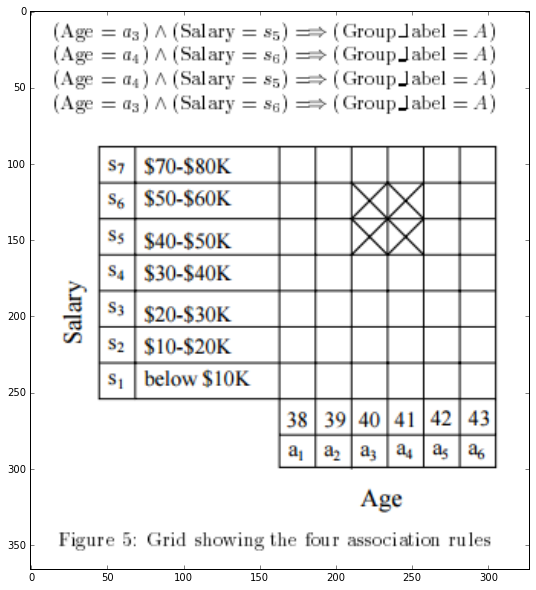

In [392]:
picture = imread('Bitset.png')
f, ax = plt.subplots(1,1, figsize=(20,10))
ax.imshow(picture)

Пример, как будет выглядеть маска (кружками отмечены полученные кластеры):

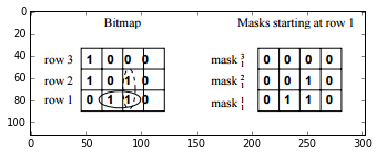

In [385]:
picture = imread('Bitset_mask.png')
imshow(picture)

Дальше с помощью полученной маски формируем кластеры и с помощью жадной стратегии объединяем маленькие кластеры в большие. Строим более общие ассоциативные правила, которые дальше можно использовать для деления множества поисковых сессий на роботные и человеческие.

Не успела закодить эту идею, к сожалению.

##### Еще одна идея:

На одной из последних лекций Ветрова по байесовским методам упоминался метод оценки плотности распределения с помощью метода парзеновского окна (метод байесовской классификации, основанный на непараметрическом восстановлении плотности по имеющейся выборке). В основе подхода лежит идея о том, что плотность выше в тех точках, рядом с которыми находится большое количество объектов выборки.

Ширина окна сильно влияет на восстановление плотности. При слишком большом окне плотность вырождается в константу. Смысл этого замечания в том, что ширину окна надо подбирать, иначе ничего хорошего не получится.

Получив таким методом плотность, можно дальше посмотреть на ее график, и те значения, плотность которых выше какого-то определенного порога, считать принадлежащими роботным сессиям. Таким образом можно сформировать вектор лейблов.

Я не успела закодить этот подход, хотя подозреваю, что он даст результаты намного лучше, чем те, что можно получить генерируя вектор лейблов при помощи кластеризации по подвыборкам признаков.

##### Выводы:

Основная проблема, которая у меня возникла - apriori, написанный мной, работает долго, поэтому искать правила с маленьким support сложно (приходится ждать около часа). Думаю, надо было не мучаться, а взять готовую реализацию алгоритма и работать с ней.

Жалко, что не успела закодить идею про группировку ассоциативных правил из http://ilpubs.stanford.edu:8090/158/1/1996-31.pdf и  про метод окна Парзена.